In [1]:
import sys
sys.path.insert(0, '../../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from preprocess import Audio_Processor
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

SR = 44100
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../../../ESC-50/audio/'

In [5]:
path_to_db='../../../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset = dataset[dataset.h_category == 0].drop(["h_category"], axis=1)
dataset = dataset.reset_index(drop=True)
dataset.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-103298-A-9.wav,1,9,crow,False,103298,A
3,1-104089-A-22.wav,1,22,clapping,False,104089,A
4,1-104089-B-22.wav,1,22,clapping,False,104089,B


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [12]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.target)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [13]:
train_X, train_y = load_audio_blockwise(dataset[dataset.fold != 1], blocksize, overlap)
print(train_X.shape)

	Processing Time: 1.2701361179351807
(608, 1, 220500)


In [14]:
test_X, test_y = load_audio_blockwise(dataset[dataset.fold == 1], blocksize, overlap)
print(test_X.shape)

	Processing Time: 0.3809547424316406
(152, 1, 220500)


## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 100
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()au
    model.add(Melspectrogram(
        sr=SR,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [16]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_1 (Melspectro (None, 128, 862, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 854, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 50, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                204832    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

Epoch 33/100
516/516 [==============================] - 38s 74ms/step - loss: 2.2462 - acc: 0.2849 - mean_absolute_error: 0.2300 - val_loss: 2.5405 - val_acc: 0.2391 - val_mean_absolute_error: 0.2404
Epoch 34/100
516/516 [==============================] - 41s 79ms/step - loss: 2.2000 - acc: 0.2829 - mean_absolute_error: 0.2242 - val_loss: 2.5540 - val_acc: 0.2500 - val_mean_absolute_error: 0.2373
Epoch 35/100
516/516 [==============================] - 40s 78ms/step - loss: 2.2006 - acc: 0.2752 - mean_absolute_error: 0.2208 - val_loss: 2.5852 - val_acc: 0.2283 - val_mean_absolute_error: 0.2395
Epoch 36/100
516/516 [==============================] - 39s 76ms/step - loss: 2.1738 - acc: 0.2965 - mean_absolute_error: 0.2174 - val_loss: 2.4736 - val_acc: 0.2174 - val_mean_absolute_error: 0.2381
Epoch 37/100
516/516 [==============================] - 38s 74ms/step - loss: 2.2133 - acc: 0.2868 - mean_absolute_error: 0.2194 - val_loss: 2.6149 - val_acc: 0.2391 - val_mean_absolute_error: 0.2376


Epoch 74/100
516/516 [==============================] - 38s 74ms/step - loss: 1.6755 - acc: 0.4593 - mean_absolute_error: 0.1198 - val_loss: 2.6674 - val_acc: 0.3152 - val_mean_absolute_error: 0.1330
Epoch 75/100
516/516 [==============================] - 39s 75ms/step - loss: 1.5861 - acc: 0.4419 - mean_absolute_error: 0.1174 - val_loss: 2.9128 - val_acc: 0.3261 - val_mean_absolute_error: 0.1308
Epoch 76/100
516/516 [==============================] - 38s 73ms/step - loss: 1.7200 - acc: 0.3857 - mean_absolute_error: 0.1161 - val_loss: 2.9796 - val_acc: 0.3152 - val_mean_absolute_error: 0.1268
Epoch 77/100
516/516 [==============================] - 38s 74ms/step - loss: 1.6329 - acc: 0.4457 - mean_absolute_error: 0.1141 - val_loss: 2.9297 - val_acc: 0.3152 - val_mean_absolute_error: 0.1287
Epoch 78/100
516/516 [==============================] - 39s 75ms/step - loss: 1.6225 - acc: 0.4341 - mean_absolute_error: 0.1169 - val_loss: 2.9236 - val_acc: 0.3152 - val_mean_absolute_error: 0.1279


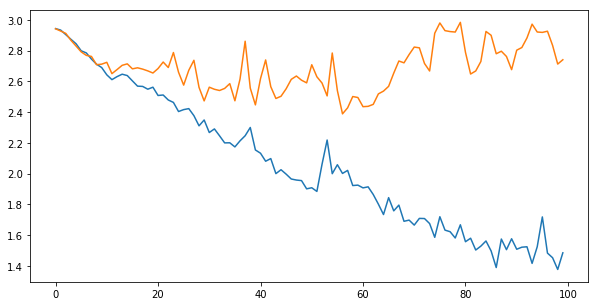

In [17]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

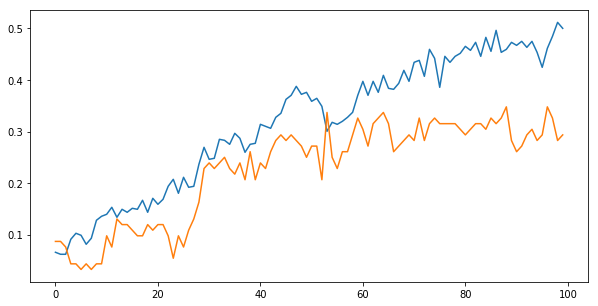

In [18]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.3223684210526316
Confusion matrix, without normalization
[[0 1 0 2 0 1 1 0 0 0 0 0 0 0 0 0 2 1 0]
 [0 6 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0]
 [1 2 0 2 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 3 0 0 0 1 1 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 1 0 0 2 0 0 0 1 2]
 [0 0 1 1 0 0 3 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 2 2 0 0 0 1 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 4 1 2 0 0 0 1 0 0 0 0]
 [0 2 0 0 0 1 0 0 0 3 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 3 4 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 2 4 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 2 0 1 0 0 0 2 0 1 0 1 0 0]
 [0 0 1 0 0 0 0 0 1 0 1 0 0 5 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 0 1 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 1 3 0 1 0 0 0 0 0 1]
 [0 1 0 0 0 1 0 1 0 0 2 0 0 1 0 0 2 0 0]
 [1 2 0 1 0 0 1 0 0 0 1 0 0 0 0 0 2 0 0]
 [0 0 1 0 0 0 0 1 0 0 4 2 0 0 0 0 0 0 0]]


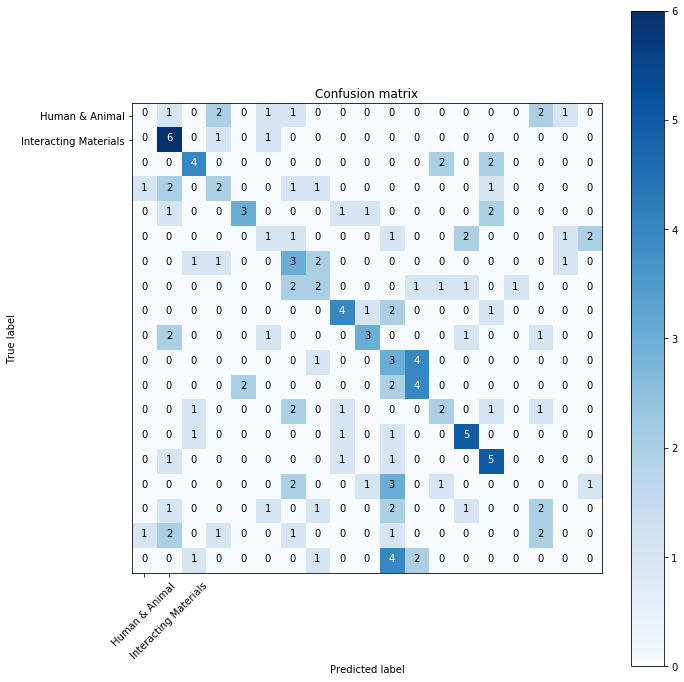

In [19]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [ ]:
import seaborn as sns
misclassified = {
    'Predicted target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

correctly_classified = {
    'Predicted h_target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

for p, prob, Y in zip(pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['Predicted h_target'].append(h_classes[p])
        misclassified['Anim_prob'].append(prob[0])
        misclassified['Interact_prob'].append(prob[1])
    else:
        correctly_classified['Predicted h_target'].append(h_classes[p])
        correctly_classified['Anim_prob'].append(prob[0])
        correctly_classified['Interact_prob'].append(prob[1])

misclassified = pd.DataFrame.from_dict(misclassified)
correctly_classified = pd.DataFrame.from_dict(correctly_classified)

In [ ]:
average_prob = misclassified.groupby('Predicted h_target').mean()
average_prob.head()

In [ ]:
average_prob = correctly_classified.groupby('Predicted h_target').mean()
average_prob.head()